In [1]:
!nvidia-smi

Mon Feb 27 20:06:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   62C    P0    24W /  60W |    227MiB /  6144MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [3]:
# device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"


device

'cuda'

In [4]:
# getting dataset

# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

# wget did not work for this kaggle notebook, hence i manually downloaded the dataset and uploaded it to kaggle

In [5]:
# loading train data

TRAINING_PATH = "tiny-imagenet-200/train"

transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

training_data = datasets.ImageFolder(root = TRAINING_PATH, transform = transform, target_transform = None)

In [6]:
# loading validation data

VAL_PATH = "tiny-imagenet-200/val"


with open("tiny-imagenet-200/val/val_annotations.txt") as f:
    lines = f.readlines()
    
val_dict = {}

for line in lines:
    parts = line.strip().split('\t')
    val_dict[parts[0]] = parts[1]
    
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])
    

val_data = datasets.ImageFolder(root = VAL_PATH, transform = transform, target_transform = None)

for i in range(len(val_data)):
    img_path, _ = val_data.imgs[i]
    img_name = os.path.basename(img_path)
    val_data.imgs[i] = (img_path, training_data.classes.index(val_dict[img_name]))

In [7]:
# data shapes

print(f"Length of training data = {len(training_data)}, Shape of Image = {training_data[0][0].shape}")
print(f"Length of validation data = {len(val_data)}, Shape of Image = {val_data[0][0].shape}")

Length of training data = 100000, Shape of Image = torch.Size([3, 227, 227])
Length of validation data = 10000, Shape of Image = torch.Size([3, 227, 227])


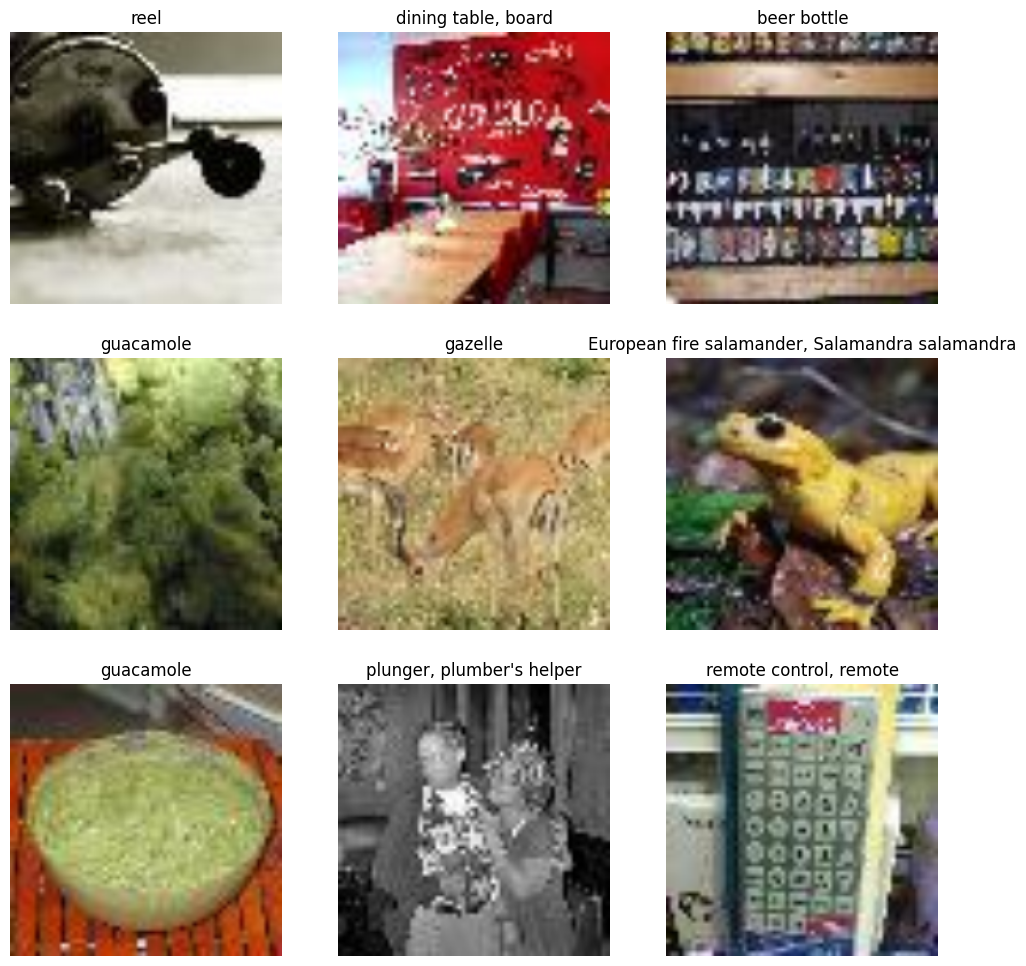

In [8]:
# label mapping file
with open("tiny-imagenet-200/words.txt", 'r') as f:
    class_names = f.readlines()
    
# mapping between WordNet IDs to class names
class_dict = {}
for line in class_names:
    line = line.split('\t')
    class_dict[line[0]] = line[1].strip()
    
    
# visualise
torch.manual_seed(1234)
fig = plt.figure(figsize=(12, 12))
rows, cols = 3, 3
for i in range(rows * cols):
    rand_idx = torch.randint(0, len(training_data), size = [1]).item()
    image, target = training_data[rand_idx]
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_dict[training_data.classes[target]])
    plt.axis(False)

In [9]:
# dataloader

BATCH_SIZE = 16

training_dataloader = DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(dataset = val_data, batch_size = BATCH_SIZE, shuffle = True)

training_images, training_targets = next(iter(training_dataloader))

print(f"Training images batch shape = {training_images.shape}")
print(f"Training targets batch shape = {training_targets.shape}")

Training images batch shape = torch.Size([16, 3, 227, 227])
Training targets batch shape = torch.Size([16])


In [10]:
# VGG-16 model

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 5, stride = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 7 * 7 * 512, out_features = 4096),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.Linear(in_features = 4096, out_features = num_classes)
        )
        self.init_weights()

    # xavier initialization
    def init_weights(self):
        torch.manual_seed(1234)
        for layer in self.conv_block_1:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_2:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_3:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_4:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_5:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        return self.classifier(x)

In [11]:
# VGG-19 model

class VGG19(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 5, stride = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 7 * 7 * 512, out_features = 4096),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.Linear(in_features = 4096, out_features = num_classes)
        )
        self.init_weights()

    # xavier initialization
    def init_weights(self):
        torch.manual_seed(1234)
        for layer in self.conv_block_1:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_2:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_3:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_4:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        for layer in self.conv_block_5:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean = 0, std = 0.01)
                nn.init.constant_(layer.bias, 0)
        
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        return classifier(x)

In [12]:
# train and test metrics 

train_loss_values = []
val_loss_values = []
val_acc_values = []
epoch_count = []

In [13]:
# training loop

def model_train(epochs, model, train_dataloader, val_dataloader, loss_func, optimizer, scheduler):

    # turn on training mode
    model.train()

    #check training device
    print(f"Training on {device}.")

    # loop through each epoch
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}/{epochs}\n-------------")

        # loop through each batch
        train_loss, train_acc = 0, 0
        total_steps = 1
        for images, classes in train_dataloader:

            #send data to device
            images, classes = images.to(device), classes.to(device)

            # computer forward pass
            y_pred = model(images)

            # compute loss
            loss = loss_func(y_pred, classes)
            train_loss += loss
            train_acc += accuracy_fn(y_true = classes, y_pred = y_pred.argmax(dim=1))

            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = train_loss / total_steps
            batch_acc = train_acc / total_steps

            if total_steps % 10 == 0:
                print(f"Training Loss: {batch_loss:.5f} - Training Accuracy: {batch_acc:.5f}%")

            total_steps += 1

        # learning rate decay
        scheduler.step()

        # performance on test set
        # turn on inference mode
        with torch.inference_mode():
            # loop through each batch
            total_val_loss, val_acc = 0, 0
            for val_images, val_classes in val_dataloader:
                # send data to device
                val_images, val_classes = val_images.to(device), val_classes.to(device)

                # forward pass
                y_val_pred = model(val_images)

                # compute loss
                val_loss = loss_func(y_val_pred, val_classes)
                total_val_loss += val_loss
                val_acc += accuracy_fn(y_true = val_classes, y_pred = y_val_pred.argmax(dim=1)
                )
            
            total_val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        print(f"[After {epoch + 1} epochs: Train Loss: {train_loss:.5f} - Train Accuracy: {train_acc:.5f}% - Validation Loss: {total_val_loss:.5f} - Validation Accuracy: {val_acc:.5f}%]")

        
        train_loss_values.append(train_loss.item())
        val_loss_values.append(total_val_loss.item())
        val_acc_values.append(val_acc)
        epoch_count.append(epoch + 1)

In [14]:
# test loop

def model_test(model, dataloader, loss_func):
    # turn on test mode
    model.eval()
    
    # turn on inference mode
    with torch.inference_mode():
        # loop through each batch
        val_loss, val_acc = 0, 0
        for images, classes in dataloader:
            # send data to device
            images, classes = images.to(device), classes.to(device)

            # forward pass
            y_pred = model(images)

            # compute loss
            loss = loss_func(y_pred, classes)
            val_loss += loss
            val_acc += accuracy_fn(y_true = classes, y_pred = y_pred.argmax(dim=1)
            )
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Loss: {val_loss:.5f} - Accuracy: {val_acc:.5f}%")
        return test_acc

In [15]:
# metric functions

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
# instantiating model

torch.manual_seed(1234)
vgg_16 = VGG16(200).to(device)

In [17]:
# loss function and optimizer

LEARNING_RATE = 0.0001

loss_func = nn.CrossEntropyLoss()

sgd = torch.optim.SGD(params = vgg_16.parameters(), lr = LEARNING_RATE, momentum = 0.9)

learning_decay = torch.optim.lr_scheduler.StepLR(optimizer = sgd, step_size = 30, gamma = 0.1)

In [18]:
# training the model

EPOCHS = 90


Training on cuda.
Epoch: 1/90
-------------
Training Loss: 5.29823 - Training Accuracy: 0.62500%
Training Loss: 5.29872 - Training Accuracy: 0.62500%
Training Loss: 5.29845 - Training Accuracy: 0.62500%
Training Loss: 5.29872 - Training Accuracy: 0.46875%
Training Loss: 5.29861 - Training Accuracy: 0.50000%
Training Loss: 5.29854 - Training Accuracy: 0.41667%
Training Loss: 5.29852 - Training Accuracy: 0.53571%
Training Loss: 5.29825 - Training Accuracy: 0.46875%
Training Loss: 5.29820 - Training Accuracy: 0.48611%
Training Loss: 5.29823 - Training Accuracy: 0.50000%
Training Loss: 5.29831 - Training Accuracy: 0.51136%
Training Loss: 5.29842 - Training Accuracy: 0.52083%
Training Loss: 5.29845 - Training Accuracy: 0.48077%
Training Loss: 5.29856 - Training Accuracy: 0.49107%
Training Loss: 5.29858 - Training Accuracy: 0.45833%
Training Loss: 5.29847 - Training Accuracy: 0.42969%
Training Loss: 5.29850 - Training Accuracy: 0.47794%
Training Loss: 5.29851 - Training Accuracy: 0.48611%
Tr

KeyboardInterrupt: 

In [ ]:

torch.manual_seed(1234)
model_train(epochs = EPOCHS, model = vgg_16, train_dataloader = training_dataloader, val_dataloader = val_dataloader, loss_func = loss_func, optimizer = sgd, scheduler = learning_decay)

In [ ]:
# evaluating the model

accuracy = model_test(model = alexnet, dataloader = val_dataloader, loss_func = loss_func)

Loss: 5.29841 - Accuracy: 0.49920%


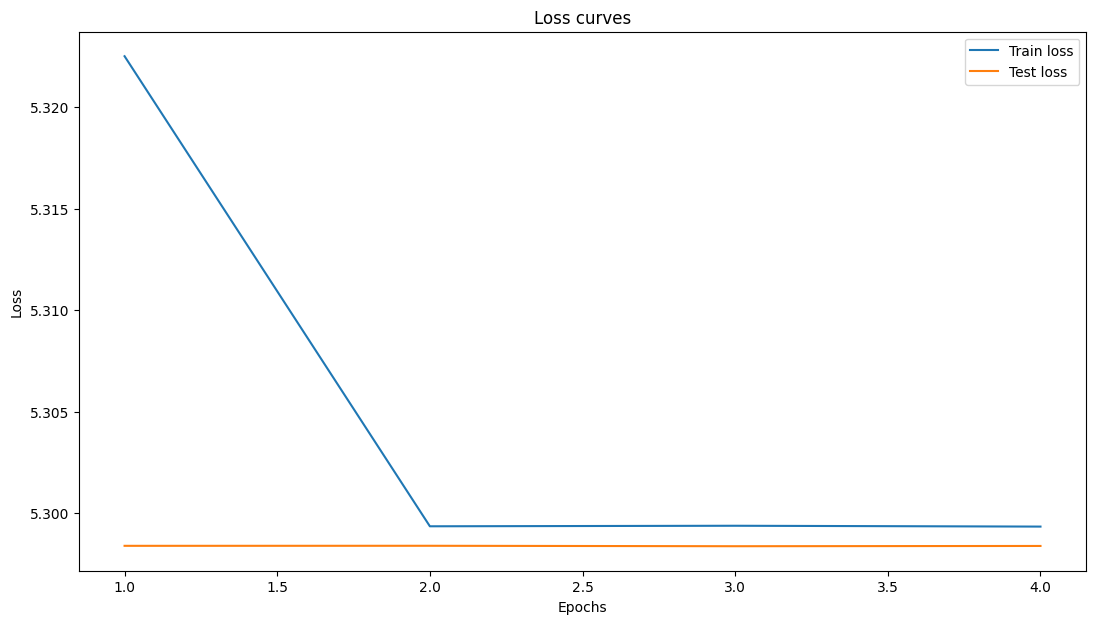

In [ ]:
# loss curve

plt.figure(figsize=(13, 7))
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

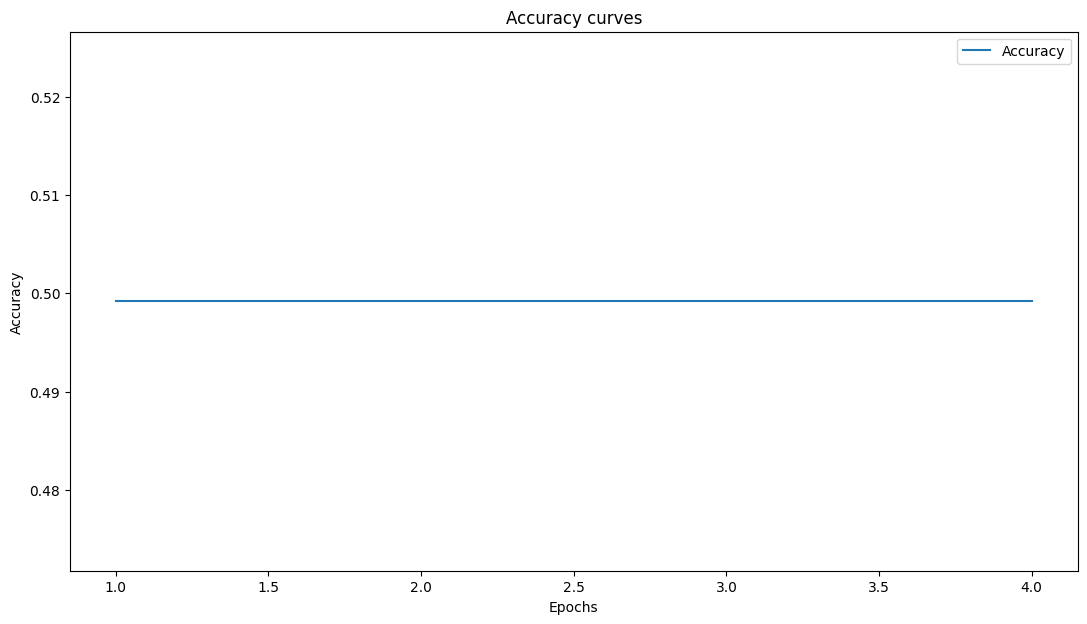

In [ ]:
# accuracy curve

plt.figure(figsize=(13, 7))
plt.plot(epoch_count, test_acc_values, label = "Accuracy")
plt.title("Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# saving the model

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "AlexNet_" + str(accuracy).replace(".", "_") + ".pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving AlexNet to {MODEL_SAVE_PATH}")
torch.save(obj = alexnet.state_dict(), f = MODEL_SAVE_PATH)